In [1]:
import logging
import shutil
import sys
import tempfile
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import nibabel as nib
import torch.nn as nn
import torch.nn.functional as F
import os.path as osp
import nibabel as nib
import monai.metrics as metrics
import sys
import pandas as pd

sys.path.append('./')

from glob import glob
from monai.networks.utils import one_hot
from utils.evaluation import data_prep, load_data, load_data_all
from utils.plotting import segmentation_visualization, segmentation_visualization_all
from utils.transforms import get_val_transforms, get_eval_post_transforms, get_train_transforms, get_infer_transforms
from utils.transforms import get_post_transforms
from utils.model import Normalizer
from pandas.plotting import parallel_coordinates
from utils.training import test_segmenter, test_NormSeg
from monai.data import Dataset, DataLoader, list_data_collate
from monai.networks.nets import DynUNet

In [2]:
# Setting
labels = {
            "vertical": 1,
            "superior longitudinal": 2,
            "inferior longitudinal": 3,
            "genioglossus": 4,
            "hyoglossus": 5,
            "background": 0,
        }

# Segmentation model: Resize vs. Crop

In [3]:
# Predictions are in the old folder
images, segmentations, predicted_segmentations = load_data('./predictions/BeLong', ['./registered_dataset/'], 
                                                           ['segmenter_900e_registered', 'segmenter_900e_registered_crop'])

In [4]:
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='train', labels = labels)

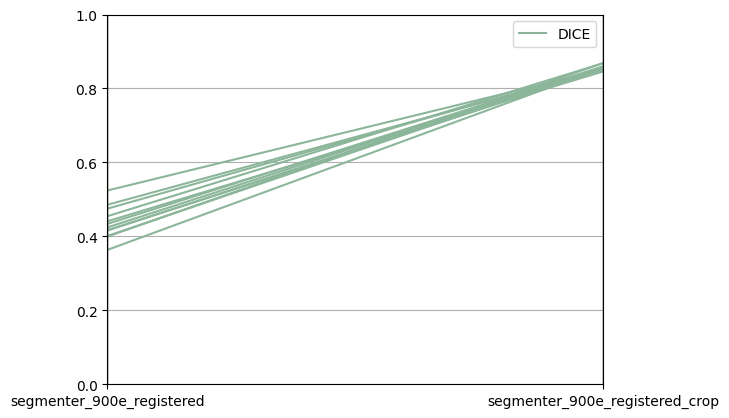

In [5]:
df = pd.DataFrame(metrics_dict)

parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()

In [6]:
df['segmenter_900e_registered_crop'].mean()

0.856625368197759

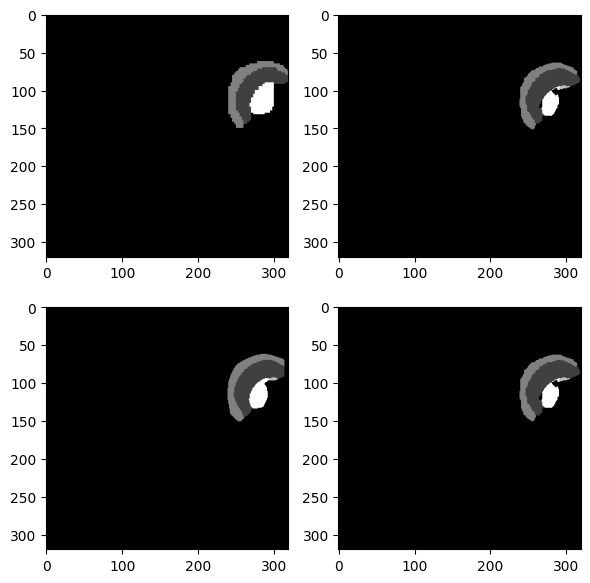

In [7]:
index = np.where(df['segmenter_900e_registered']==df['segmenter_900e_registered'].min())[0][0]
segmentation_visualization(files_list, n_predictions=2, index=2)

# Crop: Registered vs. unregistered

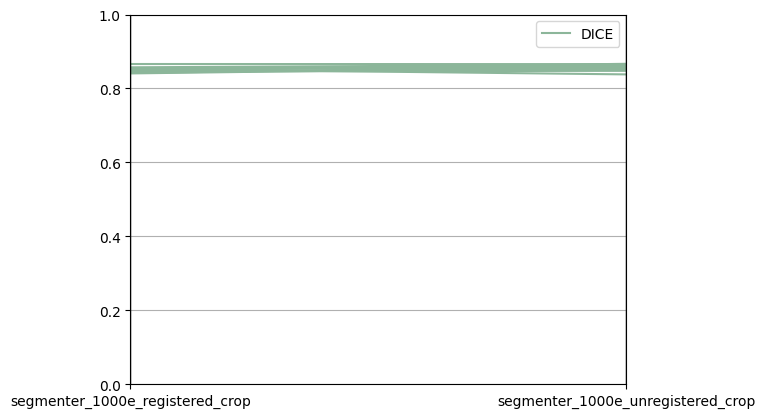

In [8]:
images, segmentations, predicted_segmentations = load_data('./predictions/BeLong/', ['./registered_dataset/','./dataset/'], 
                                                           ['segmenter_1000e_registered_crop', 'segmenter_1000e_unregistered_crop'])

metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='train', labels = labels)

df = pd.DataFrame(metrics_dict)

parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()

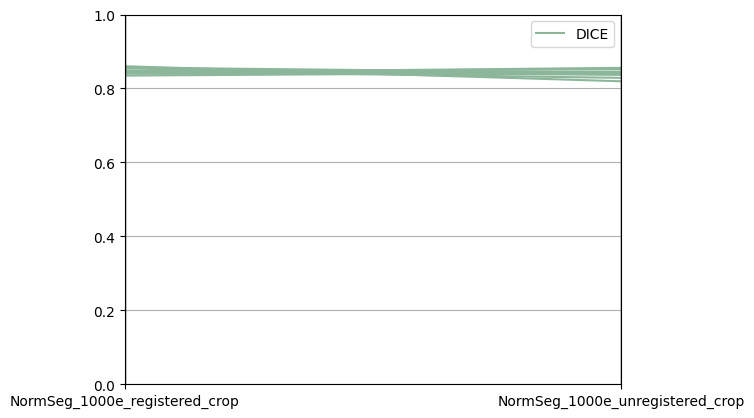

In [9]:
images, segmentations, predicted_segmentations = load_data('./predictions/BeLong/', ['./registered_dataset/','./dataset/'], 
                                                           ['NormSeg_1000e_registered_crop', 'NormSeg_1000e_unregistered_crop'])

metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='train', labels = labels)

df = pd.DataFrame(metrics_dict)

parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()

# BeLong T2w

## Experiment 1: Segmentation vs Norm + Segmentation models

In [3]:
images, segmentations, predicted_segmentations = load_data('./predictions/training_BeLong', ['./dataset/'], 
                                                           ['segmenter_1000e_unregistered_crop', 'NormSeg_1000e_unregistered_crop'])

In [4]:
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='train', labels = labels)

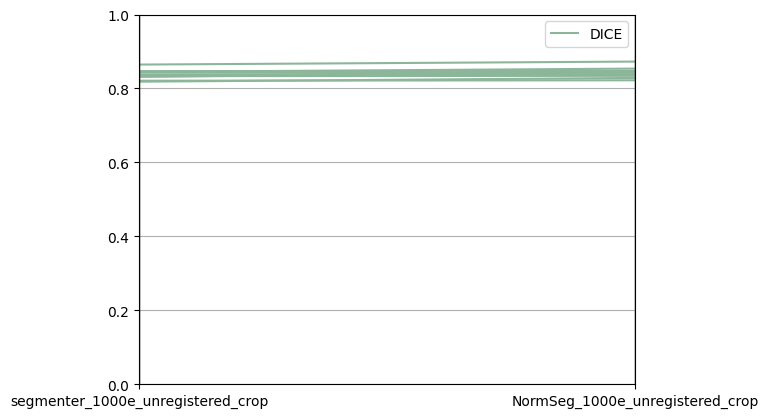

In [5]:
df = pd.DataFrame(metrics_dict)

parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()

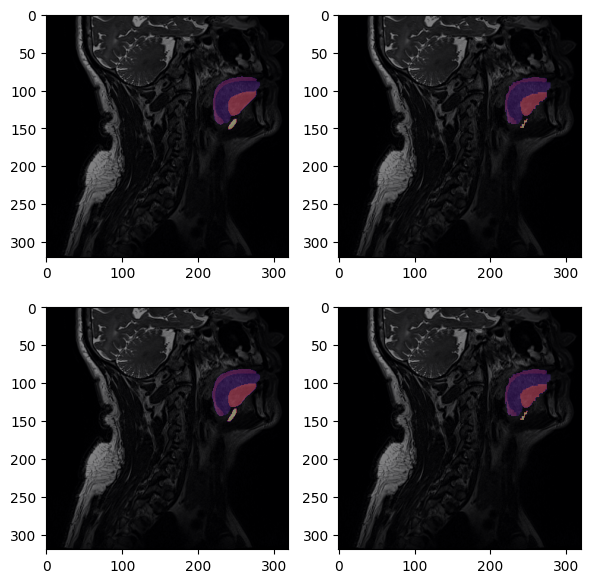

In [6]:
index = np.where(df['segmenter_1000e_unregistered_crop']==df['segmenter_1000e_unregistered_crop'].min())[0][0]
segmentation_visualization(files_list, n_predictions=2, index=2, save = False)

## Experiment 2: TTA on validation set using GT

In [7]:
def load_data_tmp(predictionsDir, dataDir, predictions,):
    """Generate lists with original images, ground-truth segmentations, and predicted segmentations filenames.

    Args:
        predictionsDir (str): path to predictions directory
        dataDir (list): list with paths to data directory
        predictions (list): list with the conditions
    Returns:
        images (list): List of the image filenames (number_of_conditions, samples)
        segmentations (list): List of the segmentation filenames (number_of_conditions, samples)
        predicted_segmentations (list): List of the predicted_segmentation filenames (number_of_conditions, samples)

    """
    segmentations = []
    images = []
    predicted_segmentations = []
    
    
    if len(dataDir)== 1 and len(predictions)!=1:
        dataDir = dataDir *  len(predictions)
        
    for i in range(len(predictions)):

        img_path = dataDir[i] + 'images/'
        seg_path = dataDir[i] + 'labels/'

        images.append(sorted(glob(os.path.join(img_path, '*.nii.gz')))[12:])
        segmentations.append(sorted(glob(os.path.join(seg_path, '*.nii.gz')))[12:])
        
        if i==0:
            predicted_segmentations.append(
                sorted(glob(os.path.join(predictionsDir, predictions[i] + '/*')))[12:])
        else:
            predicted_segmentations.append(
                sorted(glob(os.path.join(predictionsDir, predictions[i] + '/*'))))

    return images, segmentations, predicted_segmentations

In [8]:
images, segmentations, predicted_segmentations = load_data_tmp('./predictions/training_BeLong/', ['./dataset/'], 
                                                           ['NormSeg_1000e_unregistered_crop',
                                                            'tta/NormSeg_1000e_unregistered_crop/200', 
                                                            'tta/NormSeg_1000e_unregistered_crop/400'])

In [9]:
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='train', labels = labels)

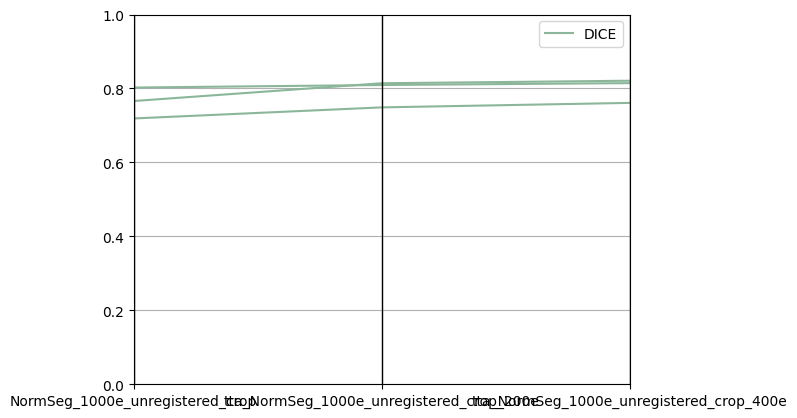

In [10]:
df = pd.DataFrame(metrics_dict)

parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()

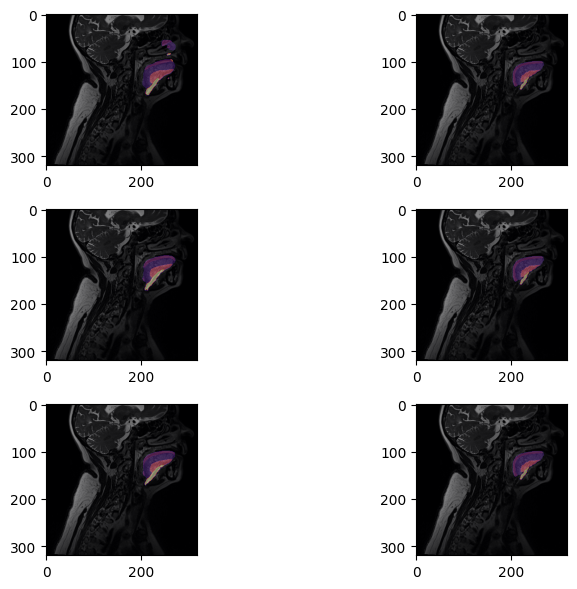

In [11]:
index = np.where(df['NormSeg_1000e_unregistered_crop']==df['NormSeg_1000e_unregistered_crop'].max())[0][0]
segmentation_visualization(files_list, n_predictions=3, index=0)

## TODO: check confusion matrix for FP and FN

## BeLong T2w registered data - TTA for each participant using the atlas as proxy

In [25]:
images, segmentations, predicted_segmentations = load_data('./predictions/BeLong_T2w/', ['./4Inference/BeLong/T2w/'], 
                                                           ['NormSeg_1000e_unregistered_crop', 'tta/NormSeg_1000e_unregistered_crop/400'], atlas=True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

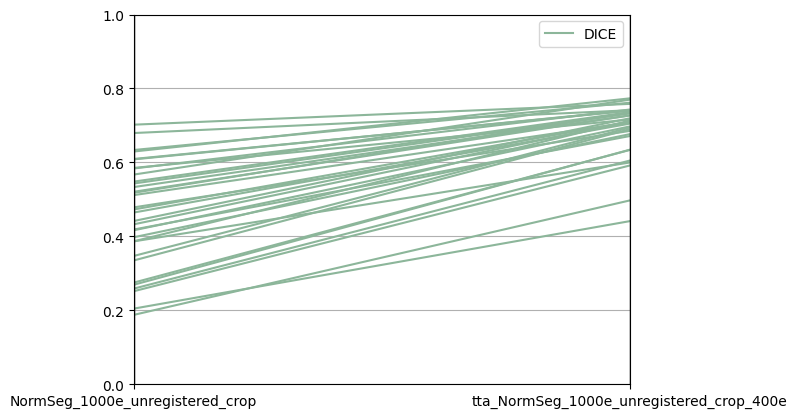

In [26]:
df = pd.DataFrame(metrics_dict)

parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()

In [58]:
for index in range(len(files_list['img2'])):
    segmentation_visualization(files_list, n_predictions=2, index=index, save=True)
    plt.close()

## BeLong T2w registered data - TTA for one participant

Best aligment - sub-013_ses-01_run-1

Worst aligment - sub-014_ses-02_acq-T

In [45]:
model = 'sub-013_ses-01_run-1'
images, segmentations, predicted_segmentations = load_data('./predictions/BeLong_T2w_' + model + '/', 
                                                           ['./4Inference/BeLong/T2w/'], 
                                                           ['tta/NormSeg_1000e_unregistered_crop/400'], atlas = True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

In [46]:
for index in range(len(files_list['img1'])):
        segmentation_visualization(files_list, n_predictions=1, index=index, save=True,  tta_model = model)
        plt.close()

## BeLong T2w registered data - all predictions

In [13]:
# All predictions
images, segmentations, predicted_segmentations = load_data_all(['./predictions/BeLong_T2w/NormSeg_1000e_unregistered_crop', 
                                                            './predictions/BeLong_T2w/tta/NormSeg_1000e_unregistered_crop/400',
                                                            './predictions/BeLong_T2w_sub-013_ses-01_run-1/tta/NormSeg_1000e_unregistered_crop/400',
                                                            './predictions/BeLong_T2w_sub-014_ses-02_acq-T/tta/NormSeg_1000e_unregistered_crop/400'],
                                                            ['./4Inference/BeLong/T2w/'], atlas = True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

In [14]:
for index in range(len(files_list['img1'])):
    segmentation_visualization_all(files_list, n_predictions=4, index=index, save=True, vmax = 2000)
    plt.close()

# EATT T2w

## Experiment 3: TTA on a new dataset (EATT T2w) using an atlas as a proxy 

In [10]:
images, segmentations, predicted_segmentations = load_data('./predictions/EATT_T2w/', ['./4Inference/EATT/T2w/'], 
                                                           ['NormSeg_1000e_unregistered_crop', 'tta/NormSeg_1000e_unregistered_crop/400'], atlas=True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

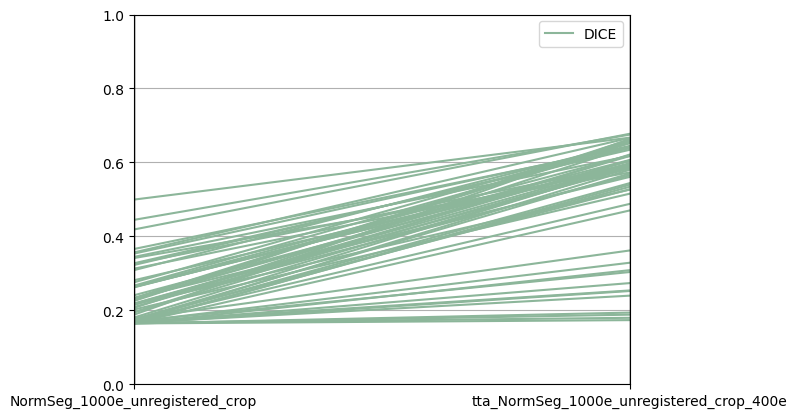

In [11]:
df = pd.DataFrame(metrics_dict)

parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()

In [61]:
for index in range(len(files_list['img2'])):
    segmentation_visualization(files_list, n_predictions=2, index=index, save=True)
    plt.close()

## Experiment 4: TTA on only one new data volume (EATT T2w) applied to the remaining volumes

Best aligment - sub-010_ses-01_acq-T

Worst aligment - sub-013_ses-01_acq-T

In [70]:
model = 'sub-013_ses-01_acq-T'

images, segmentations, predicted_segmentations = load_data('./predictions/EATT_T2w_' + model + '/', 
                                                           ['./4Inference/EATT/T2w/'], 
                                                           ['tta/NormSeg_1000e_unregistered_crop/400'], atlas = True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

In [62]:
for index in range(len(files_list['img1'])):
    segmentation_visualization(files_list, n_predictions=1, index=index, save=True,  tta_model = model)
    plt.close()

## All predictions

In [6]:
# All predictions
images, segmentations, predicted_segmentations = load_data_all(['./predictions/EATT_T2w/NormSeg_1000e_unregistered_crop', 
                                                            './predictions/EATT_T2w/tta/NormSeg_1000e_unregistered_crop/400',
                                                            './predictions/EATT_T2w_sub-010_ses-01_acq-T/tta/NormSeg_1000e_unregistered_crop/400',
                                                            './predictions/EATT_T2w_sub-013_ses-01_acq-T/tta/NormSeg_1000e_unregistered_crop/400'],
                                                            ['./4Inference/EATT/T2w/'], atlas = True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)
for index in range(len(files_list['img1'])):
    segmentation_visualization_all(files_list, n_predictions=4, index=index, save=True,)
    plt.close()

# BeLong T1w

## Experiment 5: TTA on images of different contrast (study case 2 - BeLong T1w) using an atlas as a proxy for TTA

In [18]:
images, segmentations, predicted_segmentations = load_data('./predictions/BeLong_T1w/', ['./4Inference/BeLong/T1w/'], 
                                                           ['NormSeg_1000e_unregistered_crop','tta/NormSeg_1000e_unregistered_crop/400'], atlas = True)

In [8]:
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

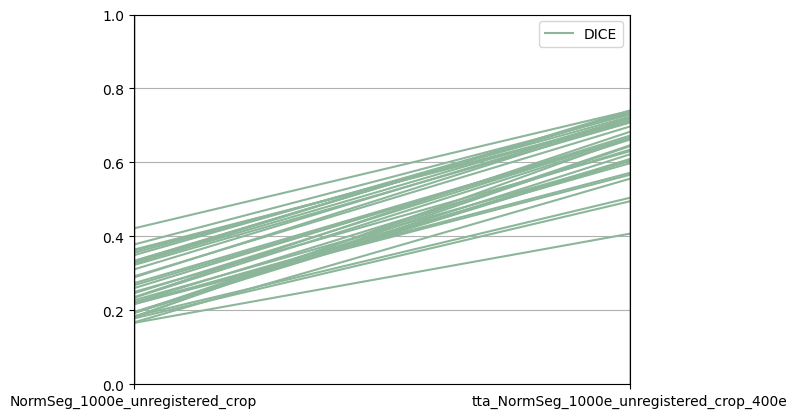

In [9]:
df = pd.DataFrame(metrics_dict)

parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()

In [64]:
for index in range(len(files_list['img1'])):
    segmentation_visualization(files_list, n_predictions=2, index=index, save=True)
    plt.close()

## Experiment 6: TTA on only one new data volume (BeLong T1w) applied to the remaining volumes

Best aligment - sub-023_ses-01_run-1

Worst aligment - sub-018_ses-01_run-1

In [15]:
model = 'sub-023_ses-01_run-1'

images, segmentations, predicted_segmentations = load_data('./predictions/BeLong_T1w_' + model + '/',
                                                           ['./4Inference/BeLong/T1w/'], 
                                                           ['tta/NormSeg_1000e_unregistered_crop/400'], atlas = True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

In [65]:
for index in range(len(files_list['img1'])):
    segmentation_visualization(files_list, n_predictions=1, index=index, save=True, tta_model = model)
    plt.close()

## All results

In [11]:
# All results
images, segmentations, predicted_segmentations = load_data_all(['./predictions/BeLong_T1w/NormSeg_1000e_unregistered_crop', 
                                                            './predictions/BeLong_T1w/tta/NormSeg_1000e_unregistered_crop/400',
                                                            './predictions/BeLong_T1w_sub-023_ses-01_run-1//tta/NormSeg_1000e_unregistered_crop/400',
                                                            './predictions/BeLong_T1w_sub-018_ses-01_run-1//tta/NormSeg_1000e_unregistered_crop/400'], 
                                                            ['./4Inference/BeLong/T1w/'], atlas = True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)
for index in range(len(files_list['img1'])):
    segmentation_visualization_all(files_list, n_predictions=4, index=index, save=True,vmax=500)
    plt.close()

# EATT T1w

## Experiment 7: TTA on images of different contrast (study case 2 - EATT T1w) using an atlas as a proxy for TTA

In [14]:
images, segmentations, predicted_segmentations = load_data('./predictions/EATT_T1w/', ['./4Inference/EATT/T1w/'], 
                                                           ['NormSeg_1000e_unregistered_crop','tta/NormSeg_1000e_unregistered_crop/400'], atlas = True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

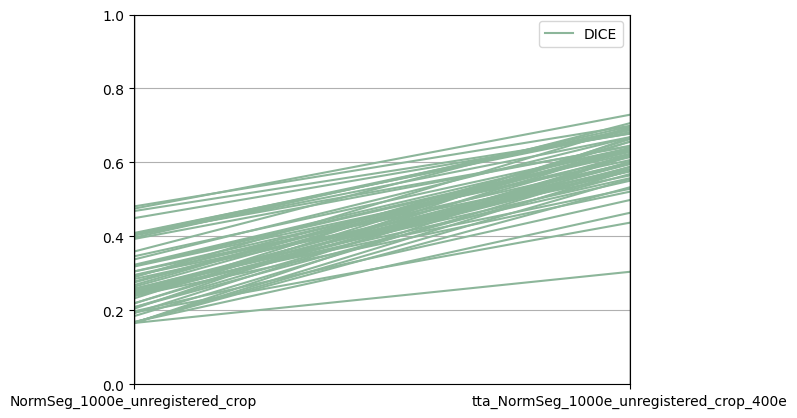

In [15]:
df = pd.DataFrame(metrics_dict)

parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()

In [66]:
for index in range(len(files_list['img1'])):
    segmentation_visualization(files_list, n_predictions=2, index=index, save=True)
    plt.close()

## Experiment 8: TTA on only one new data volume (EATT T1w) applied to the remaining volumes

Best aligment - sub-057_ses-01_run-1

Worst aligment - sub-013_ses-01_acq-M

In [20]:
model = 'sub-013_ses-01_acq-M'

images, segmentations, predicted_segmentations = load_data('./predictions/EATT_T1w_' + model + '/', ['./4Inference/EATT/T1w/'], 
                                                           ['tta/NormSeg_1000e_unregistered_crop/400'], atlas = True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

In [67]:
for index in range(len(files_list['img1'])):
    segmentation_visualization(files_list, n_predictions=1, index=index, save=True,  tta_model = model)
    plt.close()

## All predictions

In [9]:
# All results
images, segmentations, predicted_segmentations = load_data_all(['./predictions/EATT_T1w/NormSeg_1000e_unregistered_crop', 
                                                            './predictions/EATT_T1w/tta/NormSeg_1000e_unregistered_crop/400',
                                                            './predictions/EATT_T1w_sub-057_ses-01_acq-M/tta/NormSeg_1000e_unregistered_crop/400',
                                                            './predictions/EATT_T1w_sub-013_ses-01_acq-M/tta/NormSeg_1000e_unregistered_crop/400'], 
                                                            ['./4Inference/EATT/T1w/'], atlas = True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)


In [10]:
for index in range(len(files_list['img1'])):
    segmentation_visualization_all(files_list, n_predictions=4, index=index, save=True,vmax=4000)
    plt.close()

## Sydney data

Manually registered the labels to participant 035

In [3]:
# All results
images, segmentations, predicted_segmentations = load_data_all(['./predictions/Sydney_T1w/NormSeg_1000e_unregistered_crop', 
                                                            './predictions/Sydney_T1w_control_sub-035_T1w_/tta/NormSeg_1000e_unregistered_crop/400'], 
                                                            ['./4Inference/Sydney/T1w/'], atlas = True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

In [6]:
for index in range(len(files_list['img1'])):
    segmentation_visualization_all(files_list, n_predictions=2, index=index, save=True,vmax=20)
    plt.close()

# Study case 1

In [16]:
# All results
images, segmentations, predicted_segmentations = load_data_all(['./predictions/BeLong_T1w_rough/NormSeg_1000e_unregistered_crop',
                                                                './predictions/BeLong_T1w_rough/tta/NormSeg_1000e_unregistered_crop/50',
                                                                './predictions/BeLong_T1w_rough/tta/NormSeg_1000e_unregistered_crop/100',
                                                                './predictions/BeLong_T1w_rough/tta/NormSeg_1000e_unregistered_crop/200',
                                                                './predictions/BeLong_T1w_rough/tta/NormSeg_1000e_unregistered_crop/400'], 
                                                            ['./4Inference/BeLong/T1w/case1/'], atlas = True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

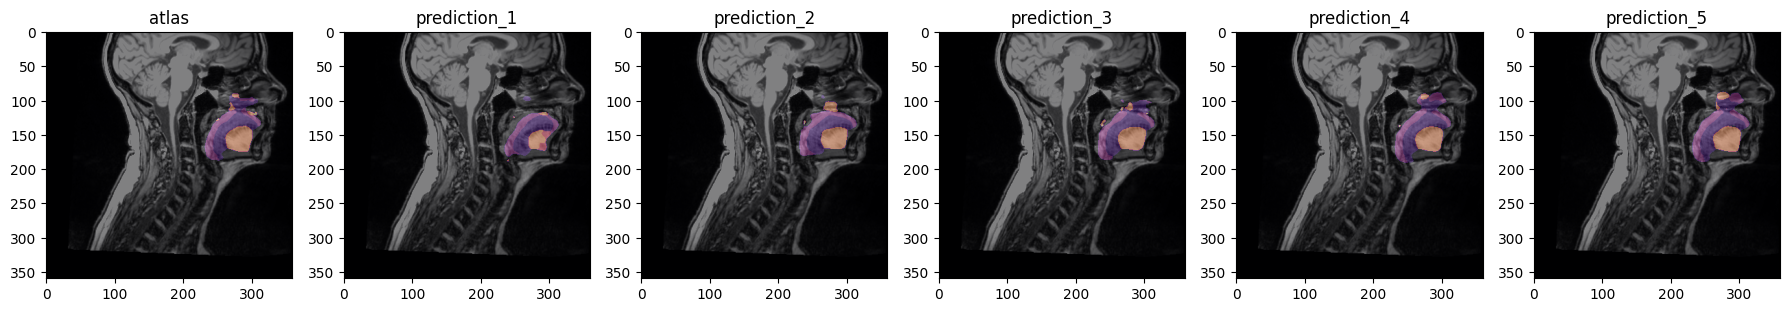

In [18]:
for index in range(len(files_list['img1'])):
    segmentation_visualization_all(files_list, n_predictions=5, index=index, vmax=500)
#     plt.close()

# Study case 2

In [3]:
# All results
images, segmentations, predicted_segmentations = load_data_all(['./predictions/BeLong_T1w_ones/NormSeg_1000e_unregistered_crop',
                                                                './predictions/BeLong_T1w_ones/tta/NormSeg_1000e_unregistered_crop/50',
                                                                './predictions/BeLong_T1w_ones/tta/NormSeg_1000e_unregistered_crop/100',
                                                                './predictions/BeLong_T1w_ones/tta/NormSeg_1000e_unregistered_crop/200',
                                                                './predictions/BeLong_T1w_ones/tta/NormSeg_1000e_unregistered_crop/400'], 
                                                            ['./4Inference/BeLong/T1w/case2/'], atlas = True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

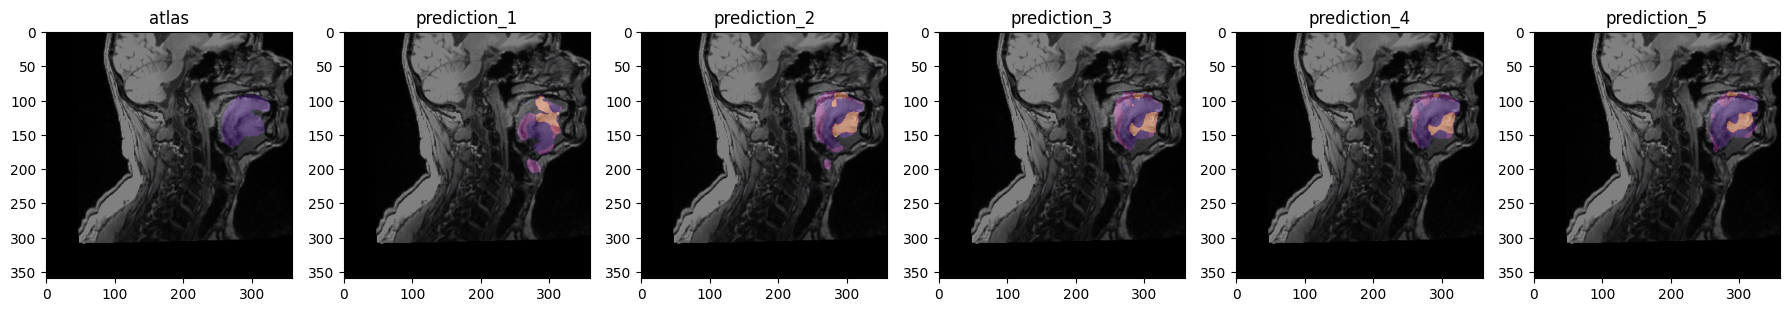

In [4]:
for index in range(len(files_list['img1'])):
    segmentation_visualization_all(files_list, n_predictions=5, index=index, vmax=500)
#     plt.close()

# Study case 3

In [3]:
# All results
images, segmentations, predicted_segmentations = load_data_all(['./predictions/BeLong_T1w/segmenter_1000e_unregistered_crop',
                                                                './predictions/BeLong_T1w_sub-023_ses-01_run-1/tta/segmenter/NormSeg_1000e_unregistered_crop/50',
                                                                './predictions/BeLong_T1w_sub-023_ses-01_run-1/tta/segmenter/NormSeg_1000e_unregistered_crop/100',
                                                                './predictions/BeLong_T1w_sub-023_ses-01_run-1/tta/segmenter/NormSeg_1000e_unregistered_crop/200',
                                                                './predictions/BeLong_T1w_sub-023_ses-01_run-1/tta/segmenter/NormSeg_1000e_unregistered_crop/400'], 
                                                            ['./4Inference/BeLong/T1w/'], atlas = True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

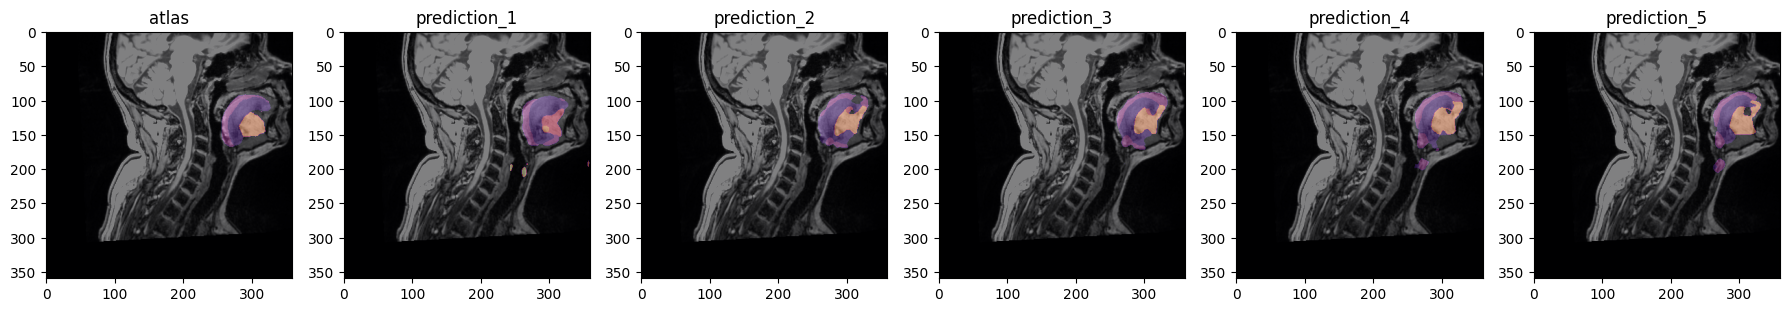

In [12]:
# for index in range(len(files_list['img1'])):
segmentation_visualization_all(files_list, n_predictions=5, index=8, vmax=500)
#     plt.close()

In [8]:
files_list['img1'][21]

'./4Inference/BeLong/T1w/images/sub-023_ses-01_run-1_T1w_reg_to_BeLong_template_Warped_correct_spacing.nii.gz'

# Study case 3 - with more images + more images and less labels

In [13]:
# All results
images, segmentations, predicted_segmentations = load_data_all(['./predictions/BeLong_T1w/segmenter_1000e_unregistered_crop',
                                                                './predictions/BeLong_T1w_sub-023_ses-01_run-1/tta/segmenter/NormSeg_1000e_unregistered_crop/400',
                                                                './predictions/BeLong_T1w_case3-moreSamples_segmenter_with/tta/segmenter/NormSeg_1000e_unregistered_crop/400',
                                                                './predictions/BeLong_T1w_case3-moreSamples-lessLabels_segmenter_with/tta/segmenter/NormSeg_1000e_unregistered_crop/400'], 
                                                            ['./4Inference/BeLong/T1w/'], atlas = True)
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='target', labels = labels)

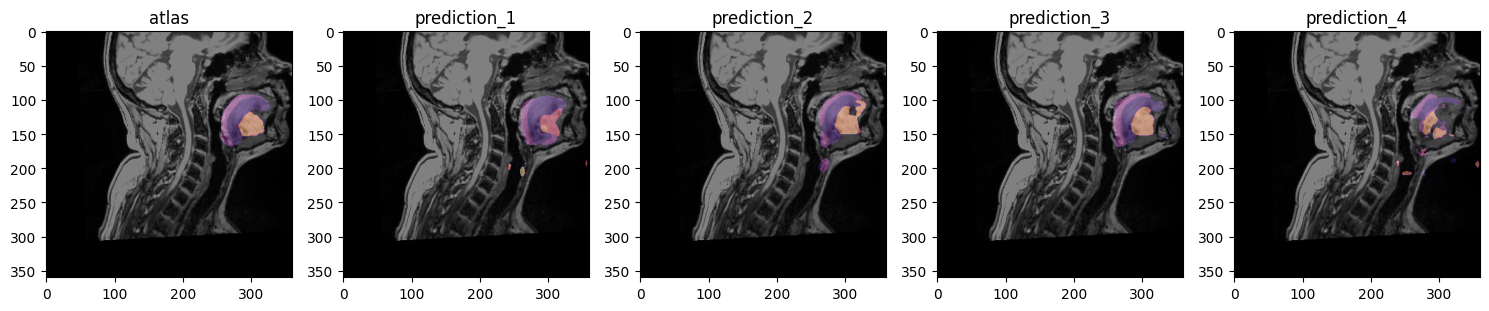

In [19]:
segmentation_visualization_all(files_list, n_predictions=4, index=8, vmax=500)


# Quality check PDFs

In [ ]:
from fpdf import FPDF
pdf = FPDF()
# imagelist is the list with all image filenames
for image in imagelist:
    pdf.add_page()
    pdf.image(image,x,y,w,h)
pdf.output("yourfile.pdf", "F")